# Notebook for preprocessing and EDA

### Import packages

In [1]:
# Import packages
from pyspark.sql import SparkSession
from pyspark import SQLContext
from pyspark.sql.functions import size, explode, col
from pyspark.ml import Pipeline

from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS as gensim_words
import spacy
sp = spacy.load('en_core_web_sm')

from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer, LemmatizerModel, StopWordsCleaner

import matplotlib.pyplot as plt

In [13]:
nltk_stopwords = set(stopwords.words('english')) \
                    .union(set(stopwords.words('german'))) \
                    .union(set(stopwords.words('french')))
gensim_stopwords = set(gensim_words)
spacy_stopwords = sp.Defaults.stop_words
# https://countwordsfree.com/stopwords
cwf_stopwords = set(line.strip() for line in open('stop_words.txt'))

all_stopwords = list( nltk_stopwords \
                        .union(gensim_stopwords) \
                        .union(spacy_stopwords) \
                        .union(cwf_stopwords) )

### Create a Spark Context  and a SQL Context

In [14]:
# Start spark session configured for spark nlp
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('SDDM') \
        .config('spark.driver.memory', '64g') \
        .config('spark.executor.memory', '32g') \
        .config('spark.executor.cores', '8') \
        .config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.0') \
        .getOrCreate()
print("Created a SparkSession")
sc = spark.sparkContext
print("Created a SparkContext")
sqlContext = SQLContext(sc)
print("Created a SQLContext")

# .config('spark.memory.fraction', '0.8') \

Created a SparkSession
Created a SparkContext
Created a SQLContext


### Load the data into a SQLContext Dataframe

In [15]:
df = (sqlContext.read.format('csv').options(header='true').load('/data/s1847503/SDDM/newdata/data.csv'))
df.show()

+--------------------+--------------------+--------------------+--------------------+
|            paper_id|               title|        list_authors|           full_text|
+--------------------+--------------------+--------------------+--------------------+
|1329bb2f949e74925...|Generation of pre...|['Xue Wu Zhang', ...|"The infection of...|
|dc079a2e9cf98fad0...|Zoonotic disease ...|['Charlotte Robin...|"Veterinary profe...|
|75af9aa0e63889abd...|Current and Novel...|['Erasmus Kotey',...|"Influenza viruse...|
|1755c4785f87bca19...|MERS: Progress on...|['*', 'Ryan Aguan...|Since its identif...|
|cc829c0f2ab2e110b...|Hepatologie Akute...|['Karoline Rutter...|"Das akute Leberv...|
|ece3d68d9b996c917...|Novel approach to...|['Ivan Timokhin',...|"Introduction | T...|
|9cd0f74020b0db181...|On the electrific...|['Martin Weiss', ...|Scientists, polic...|
|0b70c1fd82bd1962a...|A dynamic model f...|['P Raja', 'Sekha...|Infectious diseas...|
|94e8acc14db64cbb1...|Critical evaluati...|['John D Di

### Initialize Annotators

In [16]:
document_assembler = DocumentAssembler() \
                        .setInputCol('full_text') \
                        .setOutputCol('document')

# Tokenizer divides the text into tokens
tokenizer = Tokenizer() \
                .setInputCols(['document']) \
                .setOutputCol('tokens')

# Finisher converts tokens to human-readable output (we need the tokens for determining the text lengths)
finisher_tokens = Finisher() \
                        .setInputCols(['tokens']) \
                        .setCleanAnnotations(False)

# Normalizer removes punctuation, numbers etc.
normalizer = Normalizer() \
                .setInputCols(['tokens']) \
                .setOutputCol('normalized') \
                .setLowercase(True)

# Lemmatizer changes each word to its lemma
lemmatizer = LemmatizerModel.pretrained() \
                .setInputCols(['normalized']) \
                .setOutputCol('lemma')

# StopWordsCleaner removes stop words    
stopwords_cleaner = StopWordsCleaner() \
                        .setInputCols(['lemma']) \
                        .setOutputCol('clean_lemma') \
                        .setCaseSensitive(False).setStopWords(all_stopwords)

# Finisher converts clean tokens to human-readable output
finisher = Finisher() \
            .setInputCols(['clean_lemma']) \
            .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


### Create Pipelines

In [17]:
# Pipeline for fully preprocessing the text
pipeline = Pipeline() \
            .setStages([
                document_assembler,
                tokenizer,
                normalizer,
                lemmatizer,
                stopwords_cleaner,
                finisher_tokens,
                finisher
             ])

### Preprocess and clean text

In [18]:
# Peprocess the data
df = pipeline.fit(df).transform(df)
df = df.select('*', size('finished_tokens').alias('text_length'))

# Keep only papers with a text length of greater than 10
print("Before removing empty papers: {} rows.".format(df.count()))
df = df.dropna(subset='full_text')
# df = df.dropduplicates(subset='full_text')
# print("Removed duplicates")
# df = df.filter(df['text_length'] > 10)
print("After removing empty papers: {} rows.".format(df.count()))
print()

df_text = df.select(
            'paper_id',
            'full_text',
            'text_length',
            col('finished_clean_lemma').alias('preprocessed'))

df = df.select(
            'paper_id',
            'title',
            'list_authors',
            'full_text')

df_text.show()

Before removing empty papers: 1329677 rows.
After removing empty papers: 404359 rows.

+--------------------+--------------------+-----------+--------------------+
|            paper_id|           full_text|text_length|        preprocessed|
+--------------------+--------------------+-----------+--------------------+
|1329bb2f949e74925...|"The infection of...|        723|[infection, newly...|
|dc079a2e9cf98fad0...|"Veterinary profe...|       1756|[veterinary, prof...|
|75af9aa0e63889abd...|"Influenza viruse...|        919|[influenza, virus...|
|1755c4785f87bca19...|Since its identif...|       3942|[identification, ...|
|cc829c0f2ab2e110b...|"Das akute Leberv...|       1832|[akute, lebervers...|
|ece3d68d9b996c917...|"Introduction | T...|        448|[introduction, qu...|
|9cd0f74020b0db181...|Scientists, polic...|        880|[scientist, polic...|
|0b70c1fd82bd1962a...|Infectious diseas...|       7535|[infectious, dise...|
|94e8acc14db64cbb1...|Respiratory multi...|       7187|[respirator

### Analyze text lengths

In [19]:
df_text.select('text_length').describe().show()

+-------+-----------------+
|summary|      text_length|
+-------+-----------------+
|  count|           404359|
|   mean|633.9327429338781|
| stddev|2344.178275750687|
|    min|                0|
|    max|           253534|
+-------+-----------------+



### Count Vectorize text

In [20]:
df_counts = df_text.withColumn('exploded_text', explode(col('preprocessed')))
print("Exploded text")
df_counts = df_counts.groupby('exploded_text').count().toPandas()
print("Converted to Pandas")
counts_dict = {df_counts.loc[i, 'exploded_text']:df_counts.loc[i, 'count'] for i in range(df_counts.shape[0])}
print("Created dictionary")

Exploded text
Converted to Pandas
Created dictionary


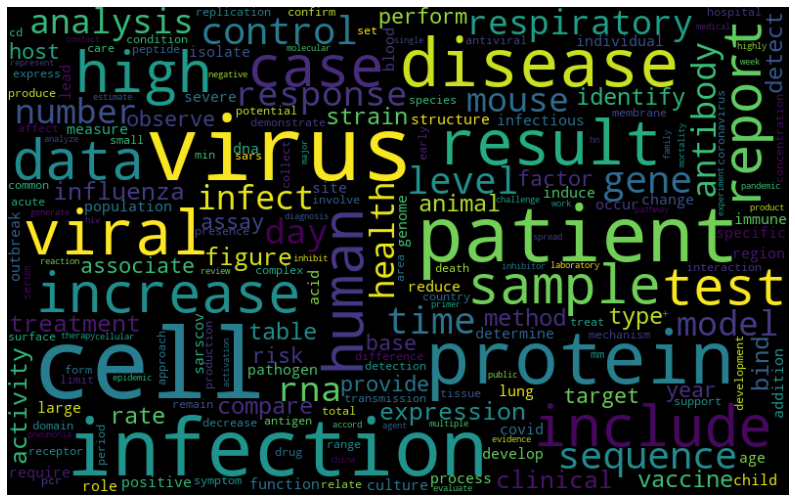

In [23]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5) \
                .generate_from_frequencies(counts_dict)
wordcloud.to_file("img/wordcloud.png")

plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Don't forget to close the Spark Context when you are done!

In [9]:
sc.stop()